In [1]:
import sys
sys.path.append(r'C:\Study\SpeechAcquisitionModel')
import numpy as np
import pandas as pd
import torch
import os
from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.speech_classification.pytorch_conv_lstm import LstmNet, LstmNetEnsemble
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']
wanted_words_tanh_transition = ['a_a', 'a_i', 'a_u', 'a_o',
                                'i_a', 'i_i', 'i_u', 'i_o',
                                'u_a', 'u_i', 'u_u', 'u_o',
                                'o_a', 'o_i', 'o_u', 'o_o' ]

wanted_words_combined = wanted_words_tanh_transition


model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 64,
    'winlen': 0.04,
    'winstep': 0.04,
    'num_nets': 5
}

save_dir = r'C:\Study\SpeechAcquisitionModel\models\speech_classification'
if not os.path.exists(save_dir):
    try:
        os.makedirs(save_dir)
    except:
        pass
best_acc = 0.0
lowest_loss = 100.0
data_dir=r'C:\Study\Speech_command_classification\speech_dataset'

preproc = AudioPreprocessorFbank(model_settings['dct_coefficient_count'], winlen=model_settings['winlen'], winstep=model_settings['winstep'])
data_iter = SpeechCommandsDataCollector(preproc,
                                        data_dir=data_dir,
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

net_fname = r"C:/Study/SpeechAcquisitionModel/models/speech_classification/simple_lstm_05_30_2019_07_12_PM_acc_0.8711.pt"


# Final test accuracy
n_mini_batch_size = 100
d = data_iter.get_data(n_mini_batch_size, 0, 'testing')
data = d['x']
labels = d['y']
seq_lengths = d['seq_len']

# load best model
net = torch.load(net_fname)
net.eval()
data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).long()


pred, hidden, _, _ = net(data, seq_lengths)
pred = torch.stack(pred).mean(dim=0)
test_loss = torch.nn.CrossEntropyLoss()(pred, labels)

print(test_loss.detach().numpy())

1.5736984


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])
torch.Size([1, 23, 18])


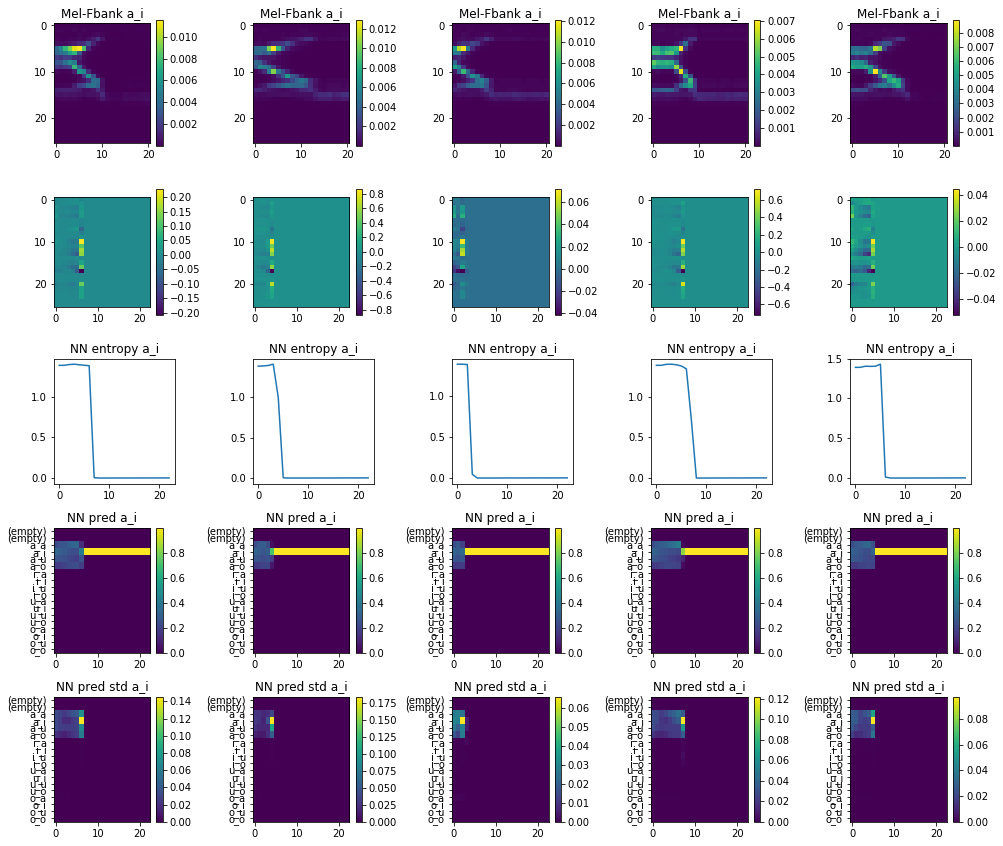

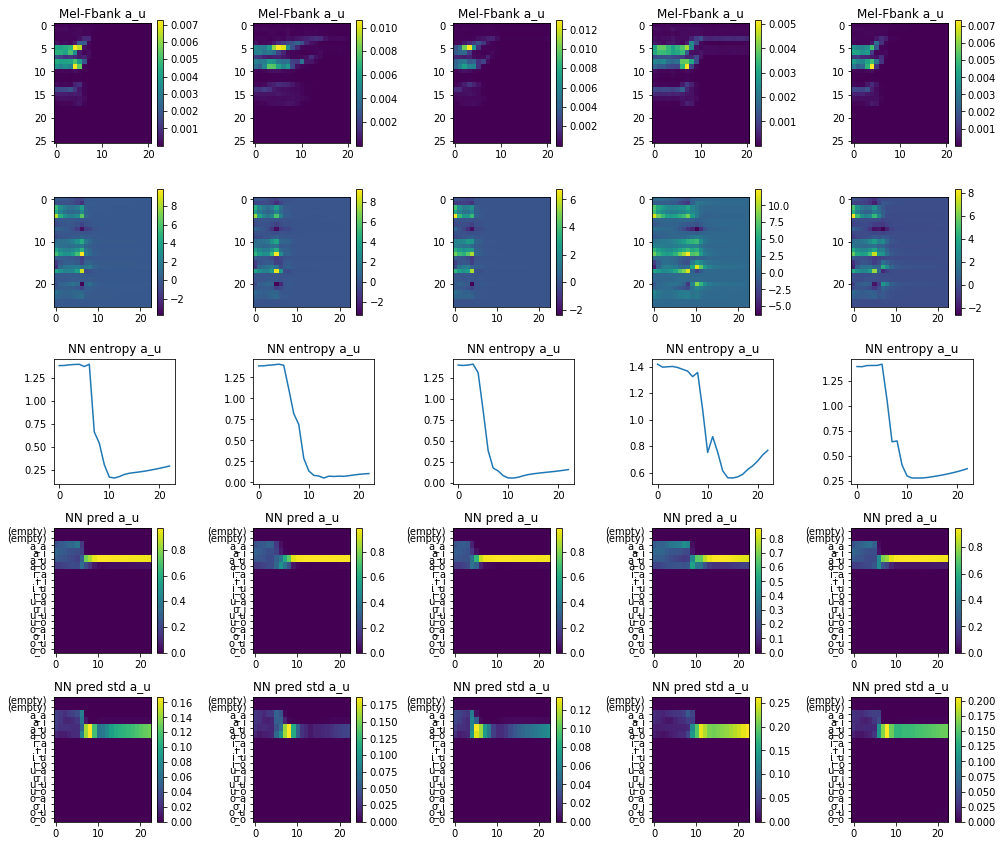

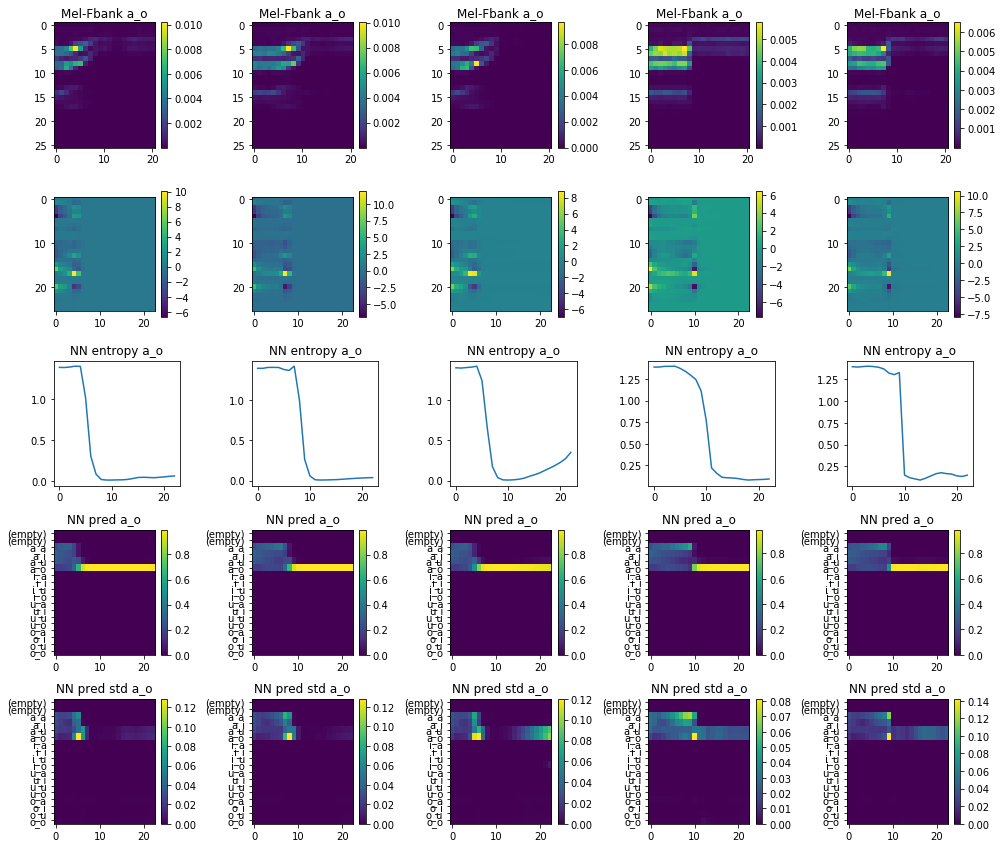

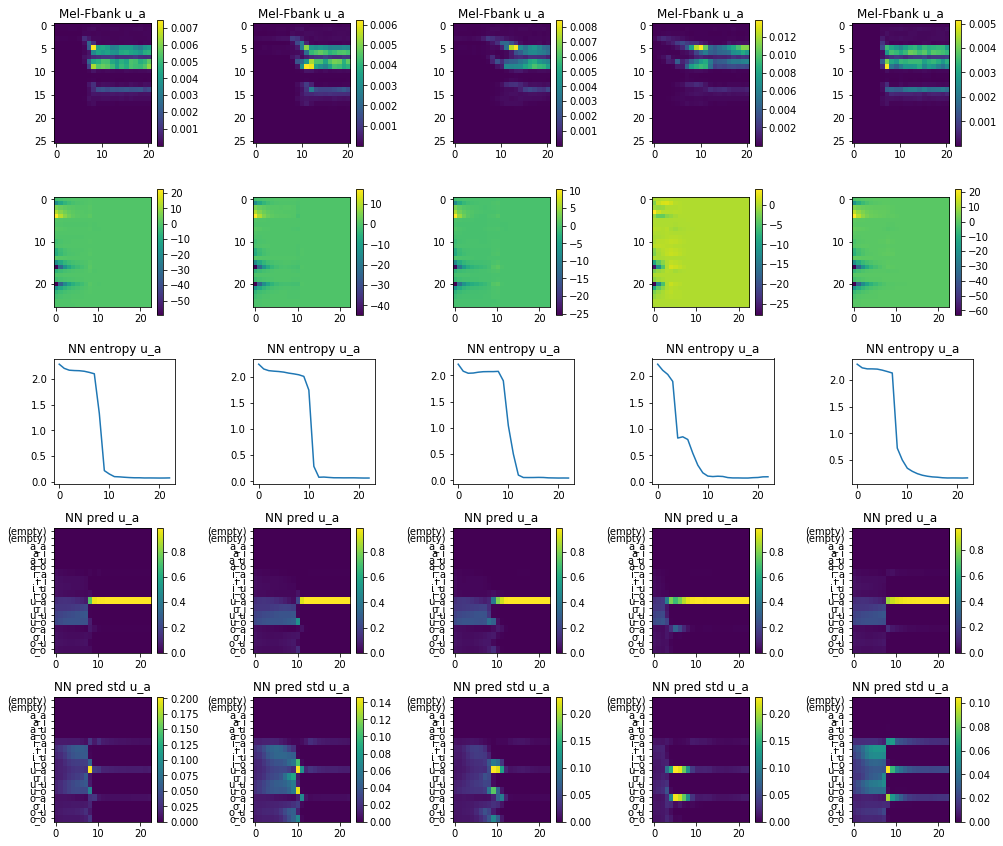

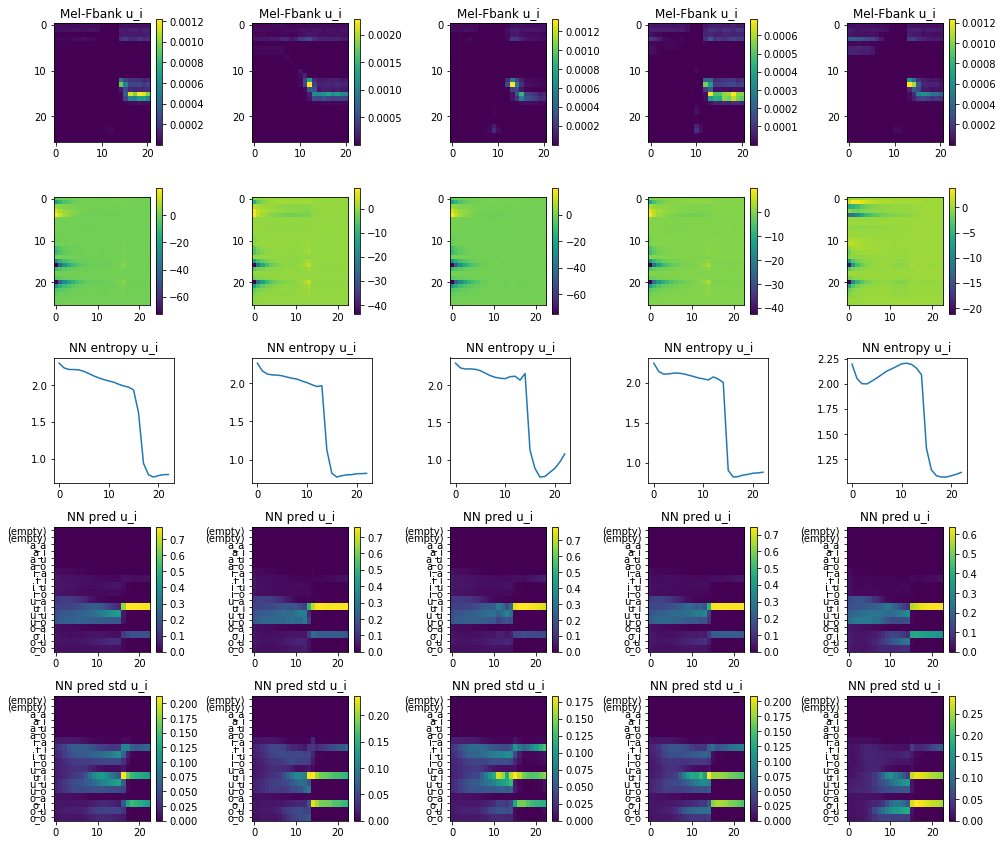

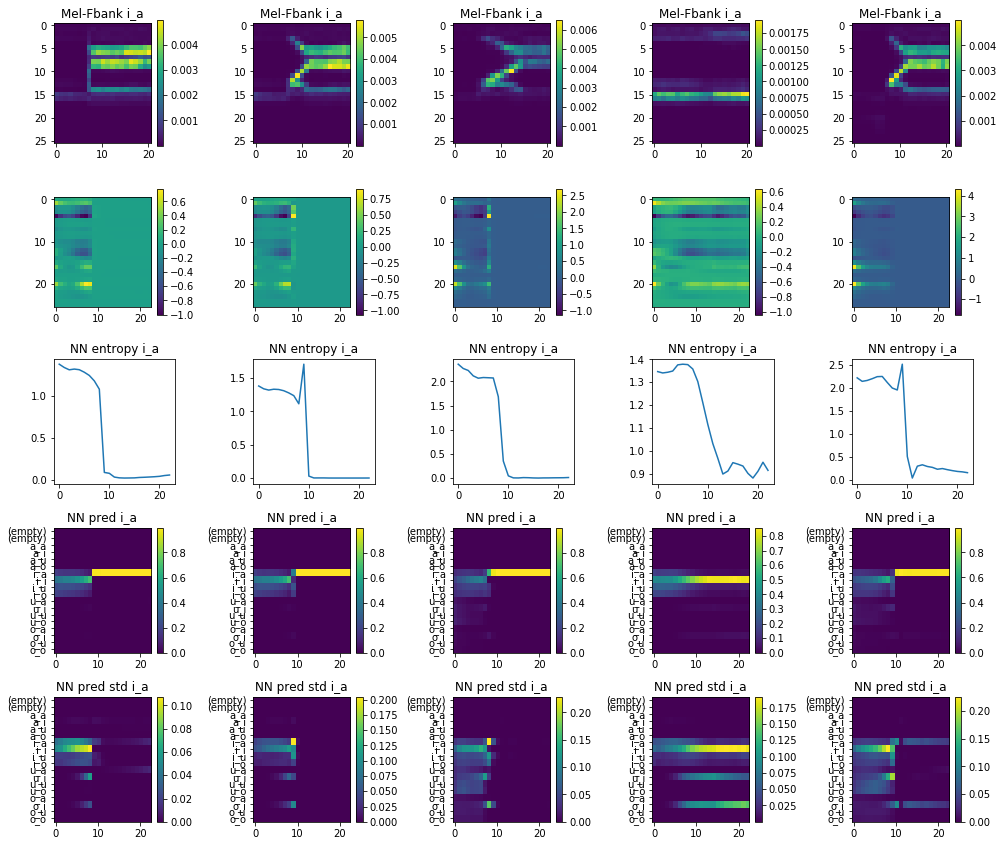

In [34]:
selected_words = ['a_i', 'a_u', 'a_o', 'u_a', 'u_i', 'i_a']
# selected_words = ['a_i', 'a_u']

n_samples_per_class = 5
n_subplots = 6
for w in selected_words:
    fnames = [f for f in os.listdir(os.path.join(data_dir, w)) if f.endswith('.wav') ]
    selected_fnames = [os.path.join(data_dir, w) + '/' + f for f in random.sample(fnames, n_samples_per_class)]
    
    plt.figure(figsize=(14,14))
    for i, f in enumerate(selected_fnames):
        preproc = AudioPreprocessorFbank(model_settings['dct_coefficient_count'], winlen=model_settings['winlen'], winstep=model_settings['winstep'])
        preprocessed = preproc(f)[2:, :]
        ax1 = plt.subplot(n_subplots, n_samples_per_class, i+1)
        asd4 = ax1.imshow(preprocessed.T[:, 2:])
        plt.colorbar(asd4)
        plt.title("Mel-Fbank " + os.path.basename(w))
        
        data = torch.tensor(torch.from_numpy(preprocessed).float().unsqueeze(dim=0), requires_grad=True)
        pred, hidden, out, full_pred_0 = net(data, np.array([data.shape[1]]))
#         pred = pred[0]
#         pred_mean = pred
        pred = torch.stack(full_pred_0)
        pred_mean = pred.mean(dim=0)
        pred_mean = torch.nn.Softmax(dim=-1)(pred_mean)
#         print(pred_mean.shape)
        true_pred_idx = wanted_words_combined.index(w)
#         print(true_pred_idx)
        true_pred = torch.zeros(model_settings['label_count'])
        true_pred[true_pred_idx] = 1.
        
        print(pred_mean.shape)
        
        cross_entopry_loss = torch.nn.CrossEntropyLoss()(pred_mean[0], torch.tensor([true_pred_idx]*pred_mean.shape[1]))
        
        # backward
#         grad = torch.autograd.grad(pred_mean[:, true_pred_idx], data)[0].numpy().squeeze()
        grad = torch.autograd.grad(cross_entopry_loss, data)[0].numpy().squeeze()
#         plt.im
        
#         print(grad.shape)
        
        full_pred_0 = torch.stack(full_pred_0)
#         print(full_pred.shape)
        full_pred = torch.nn.Softmax(dim=-1)(full_pred_0)
        full_pred_std = full_pred.std(dim=0).detach().cpu().numpy().squeeze()
#         print(full_pred.shape)
#         print(full_pred_std.shape)
        full_pred = full_pred.mean(dim=0).squeeze()
#         print(full_pred.shape)
#         print(full_pred.shape)
        log_full_pred = torch.nn.LogSoftmax(dim=-1)(full_pred_0)
        log_full_pred = log_full_pred.mean(dim=0).squeeze()
        
        entropy = -1 * (full_pred * log_full_pred).sum(dim=-1)
        
#         print(entropy.shape)

        ax2 = plt.subplot(n_subplots, n_samples_per_class, n_samples_per_class + i + 1)
        awsd3 = ax2.imshow(grad.T)
        plt.colorbar(awsd3)


        ax2 = plt.subplot(n_subplots, n_samples_per_class, 2*n_samples_per_class + i + 1)
        ax2.plot(entropy.detach().cpu().numpy())
#         ax2.imshow(out[0].detach().cpu().numpy().squeeze().T)
        
        plt.title("NN entropy " + os.path.basename(w))
        
#         print(log_full_pred.shape)
#         print(model_settings['label_count'])
        

        
        ax4 = plt.subplot(n_subplots, n_samples_per_class, 3*n_samples_per_class + i + 1)
        asd4 = ax4.imshow(full_pred.detach().cpu().numpy().squeeze().T, aspect='auto')
        ax = plt.gca()
        ax.set_yticks(np.arange(0, model_settings['label_count'], 1))
        labels=['(empty)', '(empty)']
        labels.extend(wanted_words_tanh_transition)
        ax.set_yticklabels(labels)
        plt.colorbar(asd4)
        plt.title("NN pred " + os.path.basename(w))
        
        ax5 = plt.subplot(n_subplots, n_samples_per_class, 4*n_samples_per_class + i + 1)
        asd5 = ax5.imshow(full_pred_std.T, aspect='auto')
        ax = plt.gca()
        ax.set_yticks(np.arange(0,  model_settings['label_count'], 1))
        labels=['(empty)', '(empty)']
        labels.extend(wanted_words_tanh_transition)
        ax.set_yticklabels(labels)
        plt.colorbar(asd5)
        plt.title("NN pred std " + os.path.basename(w))
        

#         ax5 = plt.subplot(5, n_samples_per_class, 4*n_samples_per_class + i + 1)
#         asd5 = ax5.imshow(full_pred_0.squeeze().mean(dim=0).detach().cpu().numpy().squeeze().T)
#         plt.colorbar(asd5)
        
        
    plt.tight_layout()
